In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

Time-decay модель.
Веса для модели расчитываются по формуле:

вес сессии = $2^{- d / s}$

где d — дней до покупки
s — количество сессий у пользователя

Почему такая формула? Давайте посмотрим на график функции

y = $2^{- x / s}$

Мы хотим увидеть, как меняется вес сессии в зависимости от 2 факторов:
- времени до сессии с покупкой
- количества сессий у пользователя

График выглядит так:

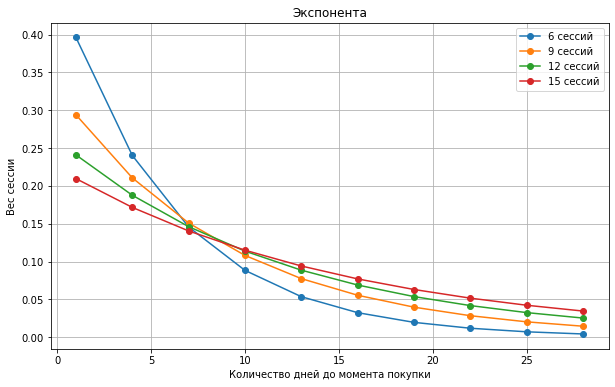

In [21]:
x = list(range(1, 31, 3))

plt.figure(figsize=(10, 6))

for s in range(6, 16, 3): 
    w = [np.exp(-d / s) for d in x]
    y = [weight / sum(w) for weight in w]  # нормируем, чтобы сумма весов была равна 1
    plt.plot(x, y, '-o', label=f'{s} сессий')

plt.legend(loc='best')
plt.xlabel('Количество дней до момента покупки')
plt.ylabel('Вес сессии')
plt.title('Экспонента')
plt.grid()
plt.show()

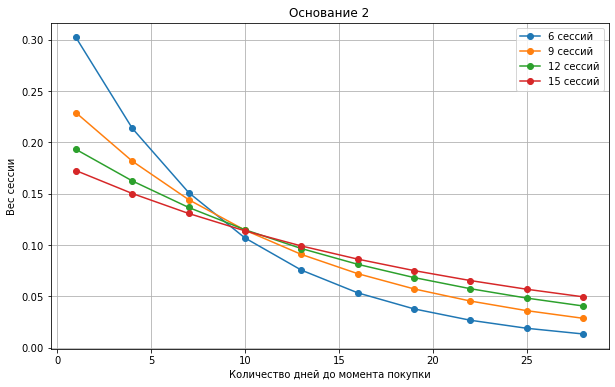

In [22]:
x = list(range(1, 31, 3))

plt.figure(figsize=(10, 6))

for s in range(6, 16, 3): 
    w = [2**(-d / s) for d in x]
    y = [weight / sum(w) for weight in w]  # нормируем, чтобы сумма весов была равна 1
    plt.plot(x, y, '-o', label=f'{s} сессий')

plt.legend(loc='best')
plt.xlabel('Количество дней до момента покупки')
plt.ylabel('Вес сессии')
plt.title('Основание 2')
plt.grid()
plt.show()

По графику можно сделать следующие выводы:
- график — убывающая функция: чем больше дней до покупки (горизонтальная ось), тем меньше вес у соответствующей сессии
- если пользователь приходил нечасто, то есть у него мало сессий, то веса очень сильно убывают с течением времени
- если пользователь часто к нам приходил, то веса убывают относительно медленно

Именно для того, чтобы функция убывала с ростом количества дней до покупки, перед количеством дней в формуле стоит знак «минус».
А для того, чтобы регулировать скорость убывания функции, мы используем количество сессий в качестве делителя.

Важный вывод — если пользователь приходит к нам редко, то для нас очень ценны сессии непосредственно перед покупкой. И наоборот, давние сессии для редкого гостя имеют мало ценности для бизнеса. 

In [ ]:
# если код выполняется в colab-ноутбуке, то замените первую строчку в следующей ячейке на эту:
# session_data = pd.read_csv('https://drive.google.com/file/d/1y1qm5nZFb89Muroe3nhcgboSTSX3ZJLi/view?usp=sharing')

In [23]:
session_data = pd.read_csv('data.csv', delimiter=';')
session_data.head()

,userId,date,trafficSource,cost,value
0,user_10,2020-01-05,telegram / posts,15.75,215.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0
2,user_10000,2020-01-19,google / cpc,8.25,0.0
3,user_1002,2020-01-03,telegram / posts,15.75,0.0
4,user_1003,2020-01-08,google / cpc,8.25,0.0


In [4]:
session_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userId         10000 non-null  object 
 1   date           10000 non-null  object 
 2   trafficSource  10000 non-null  object 
 3   cost           10000 non-null  float64
 4   value          10000 non-null  float64
dtypes: float64(2), object(3)
memory usage: 390.8+ KB


In [24]:
# изменение форматов данных для удобства
session_data['date'] = [datetime.strptime(x, '%Y-%m-%d') for x in session_data['date']]
session_data[['cost', 'value']] = session_data[['cost', 'value']].astype(float)

# группировка и суммирования, чтобы объединить покупки с одинакового канала в один день
session_data = session_data.groupby(['userId', 'date', 'trafficSource'])['cost', 'value'].sum().reset_index()
session_data = session_data.sort_values(by=['userId', 'date'])
session_data.head()

,userId,date,trafficSource,cost,value
0,user_10,2020-01-05,telegram / posts,15.75,215.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0
2,user_10000,2020-01-19,google / cpc,8.25,0.0
3,user_1002,2020-01-03,telegram / posts,15.75,0.0
4,user_1003,2020-01-08,google / cpc,8.25,0.0


In [25]:
# таблица только с датами покупок, нужна для time-decay модели

purchases_only = session_data[session_data['value'] > 0][['userId', 'date']]
purchases_only = purchases_only.groupby('userId')['date'].max().reset_index()
purchases_only.columns = ['userId', 'purchaseDate']
purchases_only.head()

,userId,purchaseDate
0,user_10,2020-01-05
1,user_1008,2020-01-09
2,user_1011,2020-01-09
3,user_1016,2020-01-15
4,user_1022,2020-01-03


+ totalSessions - всего сессий для каждого юзера
+ totalValue - доход с каждого юзера
+ sessionNumber - порядковый номер сессии
+ purchaseDate - дата последней покупки

In [28]:
# расчет вспомогательных колонок

session_data['totalSessions'] = session_data.groupby('userId')['date'].transform(lambda x: x.count())
session_data['totalValue'] = session_data.groupby('userId')['value'].transform(lambda x: x.sum())
session_data['sessionNumber'] = session_data.groupby('userId').cumcount() + 1

session_data = session_data.merge(purchases_only, on='userId', how='left')
session_data.head()

,userId,date,trafficSource,cost,value,totalSessions,totalValue,sessionNumber,purchaseDate
0,user_10,2020-01-05,telegram / posts,15.75,215.0,1,215.0,1,2020-01-05
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0,2,0.0,1,NaT
2,user_10000,2020-01-19,google / cpc,8.25,0.0,2,0.0,2,NaT
3,user_1002,2020-01-03,telegram / posts,15.75,0.0,1,0.0,1,NaT
4,user_1003,2020-01-08,google / cpc,8.25,0.0,2,0.0,1,NaT


In [37]:
pd.NaT is None

False

In [40]:
# расчет весов time-decay модели

session_data['daysToPurchase'] = [(x - y).days if x else 0
                                  for x, y in zip(session_data['purchaseDate'], session_data['date'])]

session_data['timeDecayWeight'] = [2**(-x / y)
                                   for x, y in zip(session_data['daysToPurchase'], session_data['totalSessions'])]

session_data['timeDecayWeight'] = session_data['timeDecayWeight'] / session_data.groupby('userId')['timeDecayWeight'].transform(lambda x: x.sum())
session_data.head()

,userId,date,trafficSource,cost,value,totalSessions,totalValue,sessionNumber,purchaseDate,daysToPurchase,timeDecayWeight
0,user_10,2020-01-05,telegram / posts,15.75,215.0,1,215.0,1,2020-01-05,0.0,1.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0,2,0.0,1,NaT,NaN,NaN
2,user_10000,2020-01-19,google / cpc,8.25,0.0,2,0.0,2,NaT,NaN,NaN
3,user_1002,2020-01-03,telegram / posts,15.75,0.0,1,0.0,1,NaT,NaN,NaN
4,user_1003,2020-01-08,google / cpc,8.25,0.0,2,0.0,1,NaT,NaN,NaN


In [41]:
# расчет выручки на основе различных моделей атрибуции

session_data['lastTouchValue'] = session_data['value']
session_data['firstTouchValue'] = [x if y == 1 else 0
                                   for x, y in zip(session_data['totalValue'], session_data['sessionNumber'])]
session_data['linearValue'] = session_data['totalValue'] / session_data['totalSessions']
session_data['timeDecayValue'] = session_data['totalValue'] * session_data['timeDecayWeight']
session_data.head()

,userId,date,trafficSource,cost,value,totalSessions,totalValue,sessionNumber,purchaseDate,daysToPurchase,timeDecayWeight,lastTouchValue,firstTouchValue,linearValue,timeDecayValue
0,user_10,2020-01-05,telegram / posts,15.75,215.0,1,215.0,1,2020-01-05,0.0,1.0,215.0,215.0,215.0,215.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0,2,0.0,1,NaT,NaN,NaN,0.0,0.0,0.0,NaN
2,user_10000,2020-01-19,google / cpc,8.25,0.0,2,0.0,2,NaT,NaN,NaN,0.0,0.0,0.0,NaN
3,user_1002,2020-01-03,telegram / posts,15.75,0.0,1,0.0,1,NaT,NaN,NaN,0.0,0.0,0.0,NaN
4,user_1003,2020-01-08,google / cpc,8.25,0.0,2,0.0,1,NaT,NaN,NaN,0.0,0.0,0.0,NaN


In [43]:
# проверка корректности расчетов

print(session_data[['lastTouchValue', 'firstTouchValue', 'linearValue', 'timeDecayValue']].sum())

lastTouchValue     131345.0
firstTouchValue    131345.0
linearValue        131345.0
timeDecayValue     131345.0
dtype: float64


In [48]:
# финальная таблица

totals = session_data.groupby('trafficSource')[['cost', 'lastTouchValue', 'firstTouchValue', 'linearValue',
                                                'timeDecayValue']].sum()

totals['lastTouchROI'] = 100*(round(totals['lastTouchValue'] / totals['cost'], 4))
totals['firstTouchROI'] = 100*(round(totals['firstTouchValue'] / totals['cost'], 4))
totals['linearROI'] = 100*(round(totals['linearValue'] / totals['cost'], 4))
totals['timeDecayROI'] = 100*(round(totals['timeDecayValue'] / totals['cost'], 4))

totals

,cost,lastTouchValue,firstTouchValue,linearValue,timeDecayValue,lastTouchROI,firstTouchROI,linearROI,timeDecayROI
trafficSource,,,,,,,,,
facebook / video,28208.00,33735.0,38547.5,34870.541667,34155.463580,119.59,136.65,123.62,121.08
google / cpc,25137.75,42557.5,41110.0,42677.333333,44794.862614,169.30,163.54,169.77,178.20
telegram / posts,35374.50,29330.0,25460.0,27610.208333,27862.806077,82.91,71.97,78.05,78.77
vk / display,4498.75,4345.0,4652.5,4116.833333,3544.756254,96.58,103.42,91.51,78.79
yandex / cpc,14025.00,21377.5,21575.0,22070.083333,20987.111474,152.42,153.83,157.36,149.64


In [49]:
totals_roi = totals[['cost', 'lastTouchROI', 'firstTouchROI', 'linearROI', 'timeDecayROI']]
totals_roi

,cost,lastTouchROI,firstTouchROI,linearROI,timeDecayROI
trafficSource,,,,,
facebook / video,28208.00,119.59,136.65,123.62,121.08
google / cpc,25137.75,169.30,163.54,169.77,178.20
telegram / posts,35374.50,82.91,71.97,78.05,78.77
vk / display,4498.75,96.58,103.42,91.51,78.79
yandex / cpc,14025.00,152.42,153.83,157.36,149.64


In [67]:
totals_roi.style.format("{:.1f}")\
.background_gradient(cmap='RdYlGn', axis=1, subset=['lastTouchROI', 'firstTouchROI', 'linearROI', 'timeDecayROI'])

,cost,lastTouchROI,firstTouchROI,linearROI,timeDecayROI
trafficSource,,,,,
facebook / video,28208.0,119.6,136.7,123.6,121.1
google / cpc,25137.8,169.3,163.5,169.8,178.2
telegram / posts,35374.5,82.9,72.0,78.0,78.8
vk / display,4498.8,96.6,103.4,91.5,78.8
yandex / cpc,14025.0,152.4,153.8,157.4,149.6


# Моделирование оптимальных бюджетов

+ модель по-умолчанию – модель по последнему касанию
+ гипотеза: другой подход к атрибуции = более эффективное распределение расходов на рекламу

In [68]:
# новый бюджет (расходы)
NEW_BUDGET = 1e6

In [71]:
# Распределяем новый бюджет пропрорционально старому
new_totals = totals_roi.copy()
new_totals['new_budget'] = NEW_BUDGET * new_totals['cost'] / new_totals['cost'].sum()

In [72]:
new_totals

,cost,lastTouchROI,firstTouchROI,linearROI,timeDecayROI,new_budget
trafficSource,,,,,,
facebook / video,28208.00,119.59,136.65,123.62,121.08,263026.369774
google / cpc,25137.75,169.30,163.54,169.77,178.20,234397.728544
telegram / posts,35374.50,82.91,71.97,78.05,78.77,329850.621014
vk / display,4498.75,96.58,103.42,91.51,78.79,41948.733729
yandex / cpc,14025.00,152.42,153.83,157.36,149.64,130776.546940


In [81]:
linearModel = new_totals[['new_budget', 'lastTouchROI', 'linearROI']]

# Заполните строчки ниже вашими расчетами:
# текущая прибыль при старой модели
linearModel['currentValue'] =  linearModel['lastTouchROI'] * linearModel['new_budget'] * 0.01
# разница ROI новой и старой моделей
linearModel['delta'] =  linearModel['linearROI'] - linearModel['lastTouchROI']
# Расходы при переходе на новую модель
linearModel['optimalSpend'] = linearModel['new_budget'] * (1 + linearModel['delta'] * 0.01)
# Доходы при переходе на новую модель
linearModel['optimalValue'] =  linearModel['optimalSpend'] * linearModel['linearROI'] * 0.01

linearModel['profit'] = linearModel['optimalValue'] - linearModel['currentValue']

print(f'Суммарный профит от линейной модели = {sum(linearModel["profit"])}')

linearModel

C:\Programs\Anaconda\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Суммарный профит от линейной модели = 10686.226972278193


,new_budget,lastTouchROI,linearROI,currentValue,delta,optimalSpend,optimalValue,profit
trafficSource,,,,,,,,
facebook / video,263026.369774,119.59,123.62,314553.235612,4.03,273626.332475,338256.872206,23703.636594
google / cpc,234397.728544,169.30,169.77,396835.354425,0.47,235499.397868,399807.327761,2971.973336
telegram / posts,329850.621014,82.91,78.05,273479.149883,-4.86,313819.880832,244936.416990,-28542.732893
vk / display,41948.733729,96.58,91.51,40514.087035,-5.07,39821.932929,36441.050823,-4073.036212
yandex / cpc,130776.546940,152.42,157.36,199329.612845,4.94,137236.908359,215955.998993,16626.386147


In [82]:
tdModel = new_totals[['new_budget', 'lastTouchROI', 'timeDecayROI']]

# Заполните строчки ниже вашими расчетами:
tdModel['currentValue'] =  tdModel['lastTouchROI'] * tdModel['new_budget'] * 0.01
tdModel['delta'] =  tdModel['timeDecayROI'] - tdModel['lastTouchROI']
tdModel['optimalSpend'] =  tdModel['new_budget'] * (1 + tdModel['delta'] * 0.01)
tdModel['optimalValue'] =  tdModel['optimalSpend'] * tdModel['timeDecayROI'] * 0.01

tdModel['profit'] = tdModel['optimalValue'] - tdModel['currentValue']

print(f'Суммарный профит от time-decay модели = {sum(tdModel["profit"])}')

tdModel

Суммарный профит от time-decay модели = 19869.830666633858


C:\Programs\Anaconda\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,new_budget,lastTouchROI,timeDecayROI,currentValue,delta,optimalSpend,optimalValue,profit
trafficSource,,,,,,,,
facebook / video,263026.369774,119.59,121.08,314553.235612,1.49,266945.462683,323217.566217,8664.330605
google / cpc,234397.728544,169.30,178.20,396835.354425,8.90,255259.126385,454871.763218,58036.408792
telegram / posts,329850.621014,82.91,78.77,273479.149883,-4.14,316194.805304,249066.648138,-24412.501745
vk / display,41948.733729,96.58,78.79,40514.087035,-17.79,34486.053998,27171.561945,-13342.525090
yandex / cpc,130776.546940,152.42,149.64,199329.612845,-2.78,127140.958935,190253.730950,-9075.881895
